# ATM Swaption Implied Volatlity Surface PCA Z-score Relative Value

The goal of this is to build a PCA model for the various curves for ATM Swaption Straddles. With that PCA model we are able to calculate the residuals of our fitted PCA model and then use a z-score to find the relative cheapness or richness of specific tenors. We are going to use a 3 Month Lookback.

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Path Management

In [3]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

## Read in Data, seperate out Expiry and Tenor, and slice last 3 months

In [4]:
df_raw = (pd.read_parquet(
    path = os.path.join(data_path, "svols.parquet"),
    engine = "pyarrow").
    drop(columns = ["field"]))

In [5]:
df_expiry_month =  (pd.DataFrame({
    "expiration": ["10", "0A", "0C", "05", "01", "02"],
    "expiry_month": [10 * 12, 1, 3, 5 *12, 12, 2 * 12]}))

In [36]:
df_expiration = (df_raw.assign(
    expiration = lambda x: x.ticker.str.split("USSN").str[1].str.strip().str[0:2]).
    merge(
        df_expiry_month,
        how = "inner",
        on = ["expiration"]).
    drop(columns = ["expiration"]).
    assign(date = lambda x: pd.to_datetime(x.date)))

In [37]:
df_count = (df_expiration.assign(
    letter_count = lambda x: x.ticker.str.len()))

df_lower, df_upper = df_count.query("letter_count == 19"), df_count.query("letter_count == 20")

In [46]:
df_lower_tenor = (df_lower.assign(
    tenor_year = lambda x: x.ticker.str.split(" ").str[0].str[-1].astype(int)).
    drop(columns = ["letter_count"]))

In [47]:
df_upper_tenor = (df_upper.assign(
    tenor_year = lambda x: x.ticker.str.split(" ").str[0].str[-2:].astype(int)).
    drop(columns = "letter_count"))

In [48]:
df_tenor = pd.concat([df_lower_tenor, df_upper_tenor])

In [49]:
max_date = df_tenor.date.max()
cutoff_date = max_date - dt.timedelta(days = 30)

df_window = (df_tenor.query(
    "date >= @cutoff_date"))

## Exploratory Data Analysis

<AxesSubplot:title={'center':'1 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'3 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'12 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'24 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'60 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

<AxesSubplot:title={'center':'120 Month Exp.'}, xlabel='Tenor: Y', ylabel='Implied Volatility'>

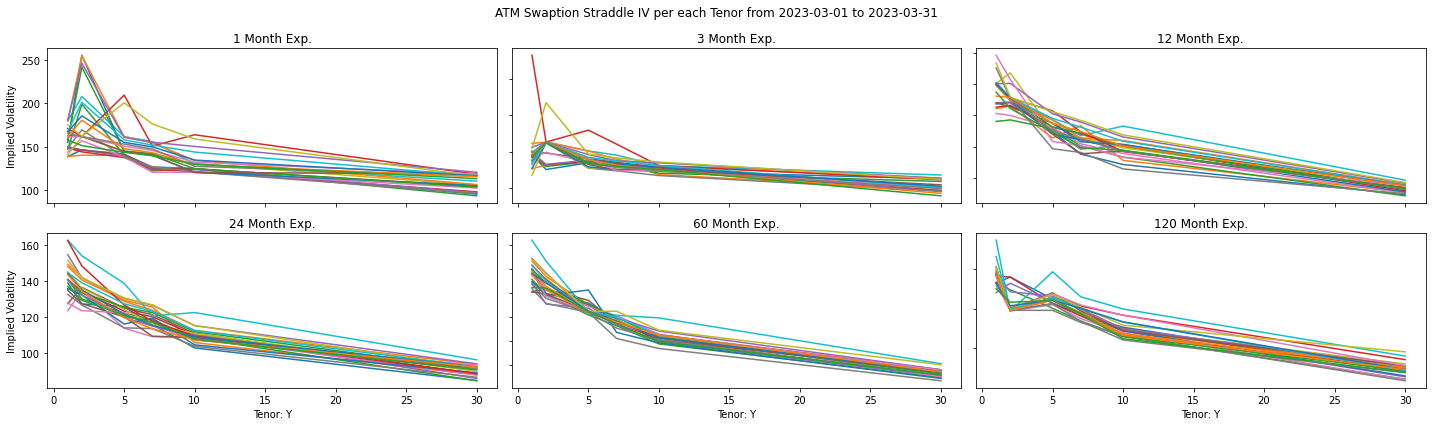

In [50]:
EXPERIES = df_window.expiry_month.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0

for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        display(df_window.query(
            "expiry_month == @expiry").
            drop(columns = ["ticker", "expiry_month"]).
            rename(columns = {"tenor_year": "Tenor: Y"}).
            pivot(index = "Tenor: Y", columns = "date", values = "value").
            plot(
                ax = axes[i,j], legend = False, title = str(expiry) + " Month Exp.",
                sharex = True, ylabel = "Implied Volatility", sharey = True))

        counter += 1

fig.suptitle("ATM Swaption Straddle IV per each Tenor from {} to {}".format(
    df_window.date.min().date(), df_window.date.max().date()))
plt.tight_layout()
plt.show()

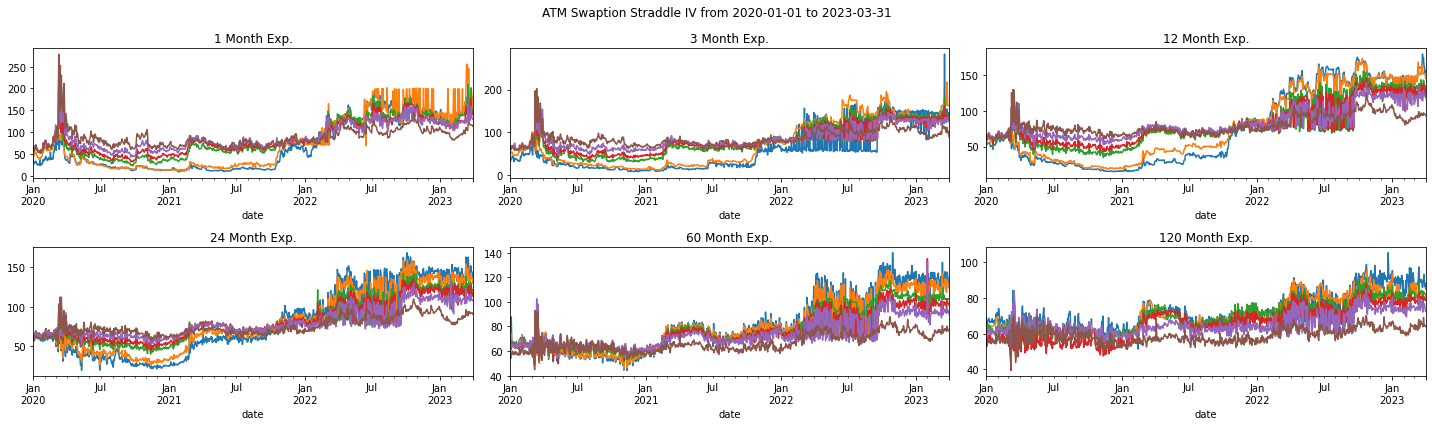

In [52]:
EXPERIES = df_tenor.expiry_month.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0

for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        (df_tenor.query(
            "expiry_month == @expiry").
            drop(columns = ["ticker", "expiry_month"]).
            rename(columns = {"tenor_year": "Tenor: Y"}).
            pivot(index = "date", columns = "Tenor: Y", values = "value").
            plot(
                ax = axes[i,j], title = str(expiry) + " Month Exp.", legend = False))

        counter += 1

fig.suptitle("ATM Swaption Straddle IV from {} to {}".format(
    df_tenor.date.min().date(), df_tenor.date.max().date()))
fig.tight_layout()
plt.show()

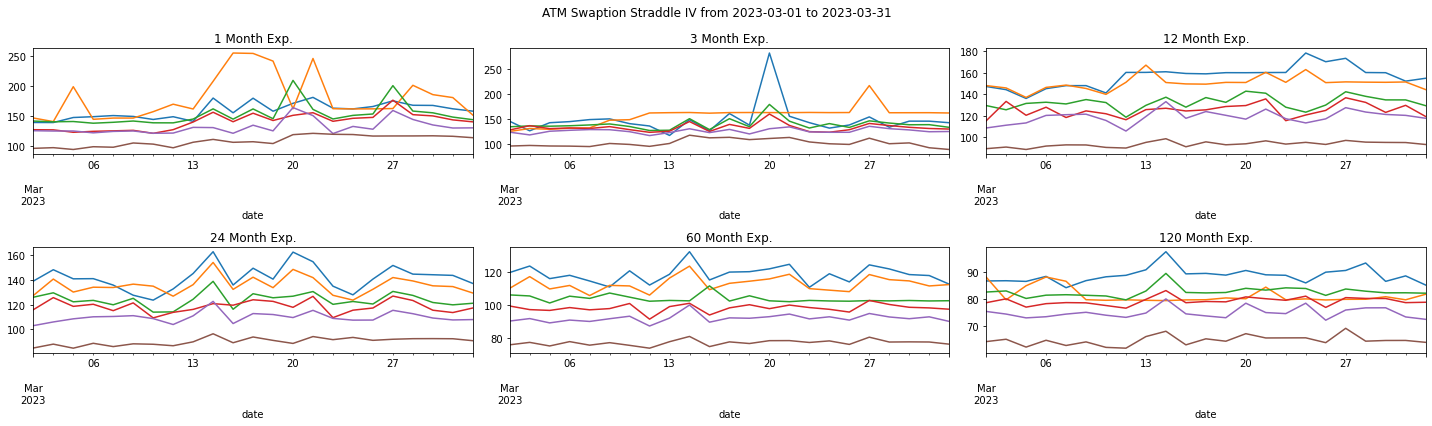

In [54]:
EXPERIES = df_window.expiry_month.drop_duplicates().sort_values().to_list()

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0

for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        (df_window.query(
            "expiry_month == @expiry").
            drop(columns = ["ticker", "expiry_month"]).
            rename(columns = {"tenor_year": "Tenor: Y"}).
            pivot(index = "date", columns = "Tenor: Y", values = "value").
            plot(
                ax = axes[i,j], title = str(expiry) + " Month Exp.", legend = False))

        counter += 1

fig.suptitle("ATM Swaption Straddle IV from {} to {}".format(
    df_window.date.min().date(), df_window.date.max().date()))
fig.tight_layout()
plt.show()

## Make PCA Model

In [55]:
def _pca_calc(df):

    pca_input = (df[
        ["date", "value", "tenor_year"]].
        pivot(index = "date", columns = "tenor_year", values = "value"))

    pca = PCA(n_components = 3)

    explained_var = (pd.DataFrame({
      "value": pca.fit(pca_input).explained_variance_ratio_,
      "variable": ["comp1", "comp2", "comp3"]}).
      assign(
          category = "explained_variance",
          date = df.date.max()))

    pca_model = pca.fit_transform(pca_input)
    pca_transform = (pd.DataFrame(
      data = pca_model,
      columns = ["comp1", "comp2", "comp3"],
      index = pca_input.index.to_list()).
      reset_index().
      rename(columns = {"index": "date"}).
      melt(id_vars = "date").
      assign(category = "pca_transform"))

    fitted_values = pca.inverse_transform(pca_model)
    pca_fit = (pd.DataFrame(
      data = fitted_values,
      columns = pca_input.columns,
      index = pca_input.index.to_list()).
      reset_index().
      rename(columns = {"index": "date"}).
      melt(id_vars = "date").
      rename(columns = {"tenor_year": "variable"}).
      assign(category = "pca_fit"))

    residuals = ((pca_input - fitted_values).reset_index().melt(
      id_vars = "date").
      rename(columns = {"tenor_year": "variable"}).
      assign(category = "residual"))

    last_date = residuals.date.max().date()
    lookback_date = last_date - dt.timedelta(days = 90)

    residuals_window = (residuals.query(
      "date > @lookback_date").
      drop(columns = ["category"]).
      pivot(index = "date", columns = "variable", values = "value"))

    residuals_zscores_window = (residuals_window - residuals_window.mean()) / residuals_window.std()
    zscores = (residuals_zscores_window.reset_index().melt(
      id_vars = "date").
      assign(category = "z_score_window"))

    residuals_window = (residuals_window.reset_index().melt(
      id_vars = "date").
      assign(category = "residual_window"))

    df_out = pd.concat([explained_var, pca_transform, pca_fit, residuals, residuals_window, zscores])
    return df_out

In [57]:
df_pca = (df_tenor.groupby(
    "expiry_month").
    apply(_pca_calc).
    reset_index().
    drop(columns = ["level_1"]))

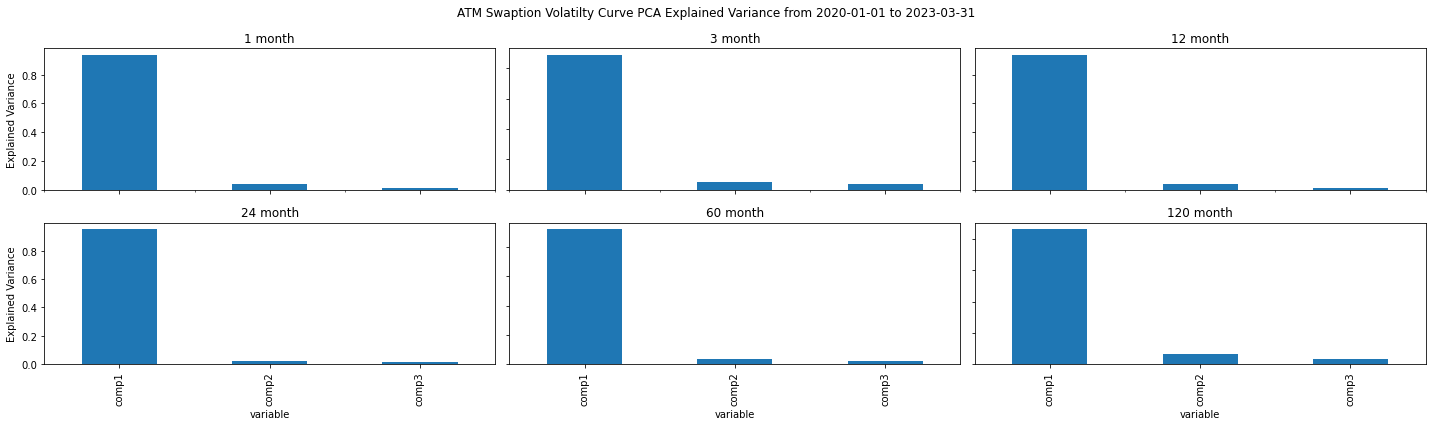

In [59]:
EXPIRIES = df_pca.expiry_month.drop_duplicates().to_list()
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0
for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        (df_pca.query(
            "expiry_month == @expiry & category == 'explained_variance'").
            set_index("variable")
            [["value"]].
            plot(
                ax = axes[i,j], kind = "bar", 
                sharey = True, sharex = True, 
                title = str(expiry) + " month",
                legend = False, ylabel = "Explained Variance"))

        counter += 1

fig.suptitle("ATM Swaption Volatilty Curve PCA Explained Variance from {} to {}".format(
    df_pca.date.min().date(), df_pca.date.max().date()))
plt.tight_layout()
plt.show()

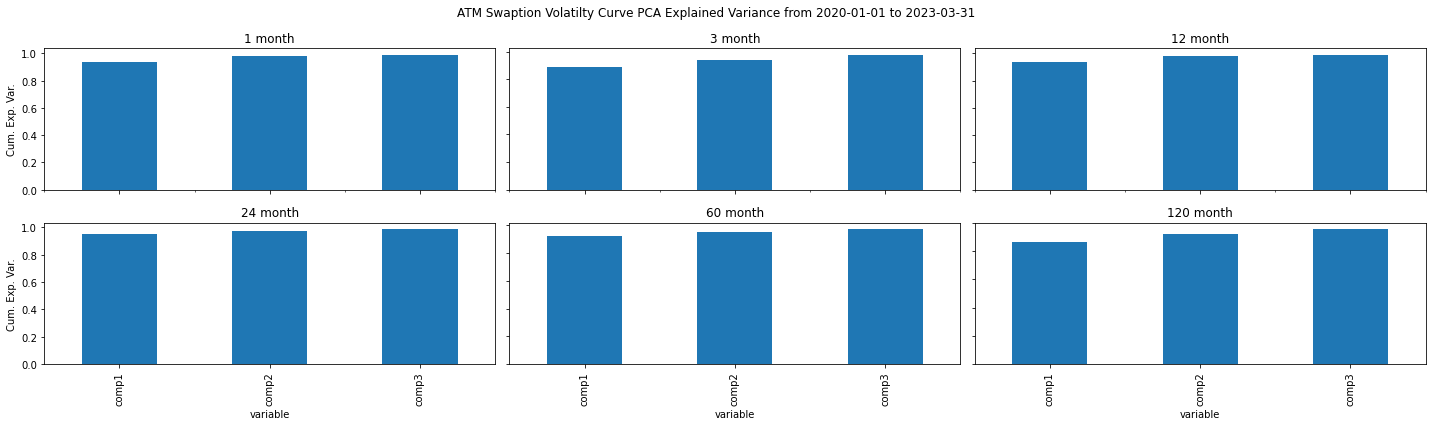

In [69]:
EXPIRIES = df_pca.expiry_month.drop_duplicates().to_list()
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,6))

counter = 0
for i in range(2):
    for j in range(3):

        expiry = EXPERIES[counter]
        (df_pca.query(
            "expiry_month == @expiry & category == 'explained_variance'").
            assign(cum_value = lambda x: np.cumsum(x.value)).
            set_index("variable")
            [["cum_value"]].
            plot(
                ax = axes[i,j], kind = "bar", 
                sharey = True, sharex = True, 
                title = str(expiry) + " month",
                legend = False, ylabel = "Cum. Exp. Var."))

        counter += 1

fig.suptitle("ATM Swaption Volatilty Curve PCA Explained Variance from {} to {}".format(
    df_pca.date.min().date(), df_pca.date.max().date()))
plt.tight_layout()
plt.show()

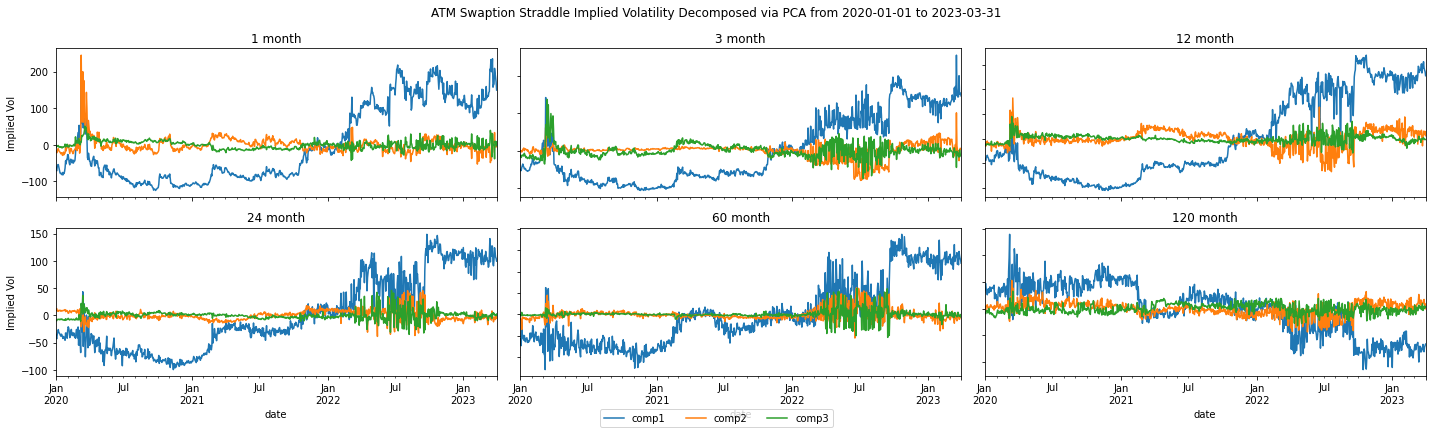

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 6))

for i, ax in enumerate(axes.flat):

    expiry = df_pca.expiry_month.drop_duplicates().iloc[i]
    data = (df_pca.query(
        "expiry_month == @expiry & category == 'pca_transform'").
        drop(columns=["expiry_month", "category"]).
        pivot(index="date", columns="variable", values="value"))
    
    data.plot(
        ax=ax, title=f"{expiry} month", legend=False,
        sharex = True, ylabel = "Implied Vol", sharey = True)
    
    if i == len(axes.flat) - 1:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=3)

fig.suptitle("ATM Swaption Straddle Implied Volatility Decomposed via PCA from {} to {}".format(
    df_pca.date.min().date(), df_pca.date.max().date()))
plt.tight_layout()
plt.show()

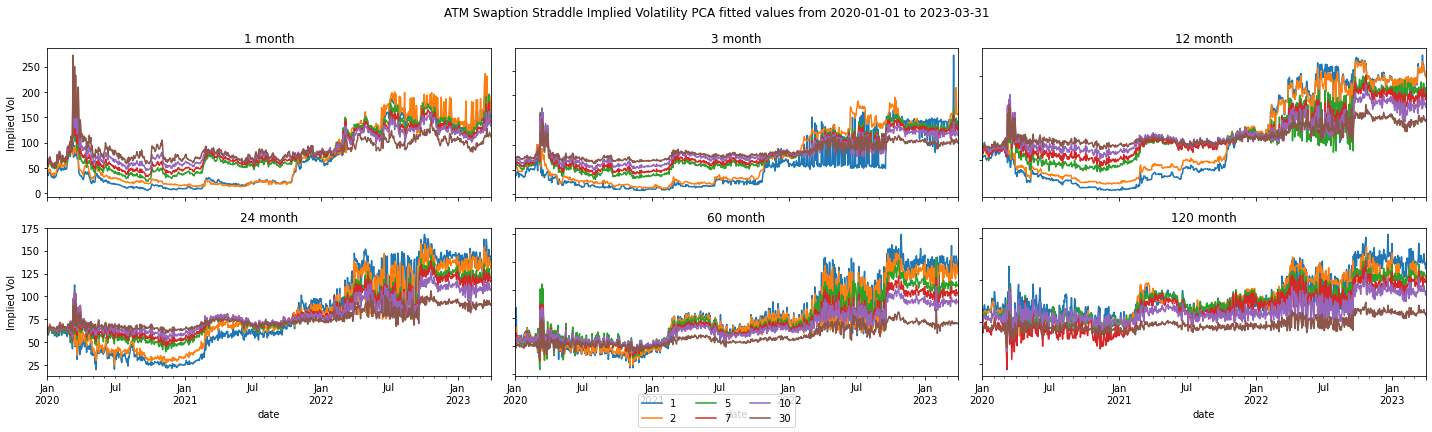

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 6))

for i, ax in enumerate(axes.flat):

    expiry = df_pca.expiry_month.drop_duplicates().iloc[i]
    data = (df_pca.query(
        "expiry_month == @expiry & category == 'pca_fit'").
        drop(columns=["expiry_month", "category"]).
        pivot(index="date", columns="variable", values="value"))
    
    data.plot(
        ax=ax, title=f"{expiry} month", legend=False,
        sharex = True, ylabel = "Implied Vol", sharey = True)
    
    if i == len(axes.flat) - 1:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=3)

fig.suptitle("ATM Swaption Straddle Implied Volatility PCA fitted values from {} to {}".format(
    df_pca.date.min().date(), df_pca.date.max().date()))
plt.tight_layout()
plt.show()

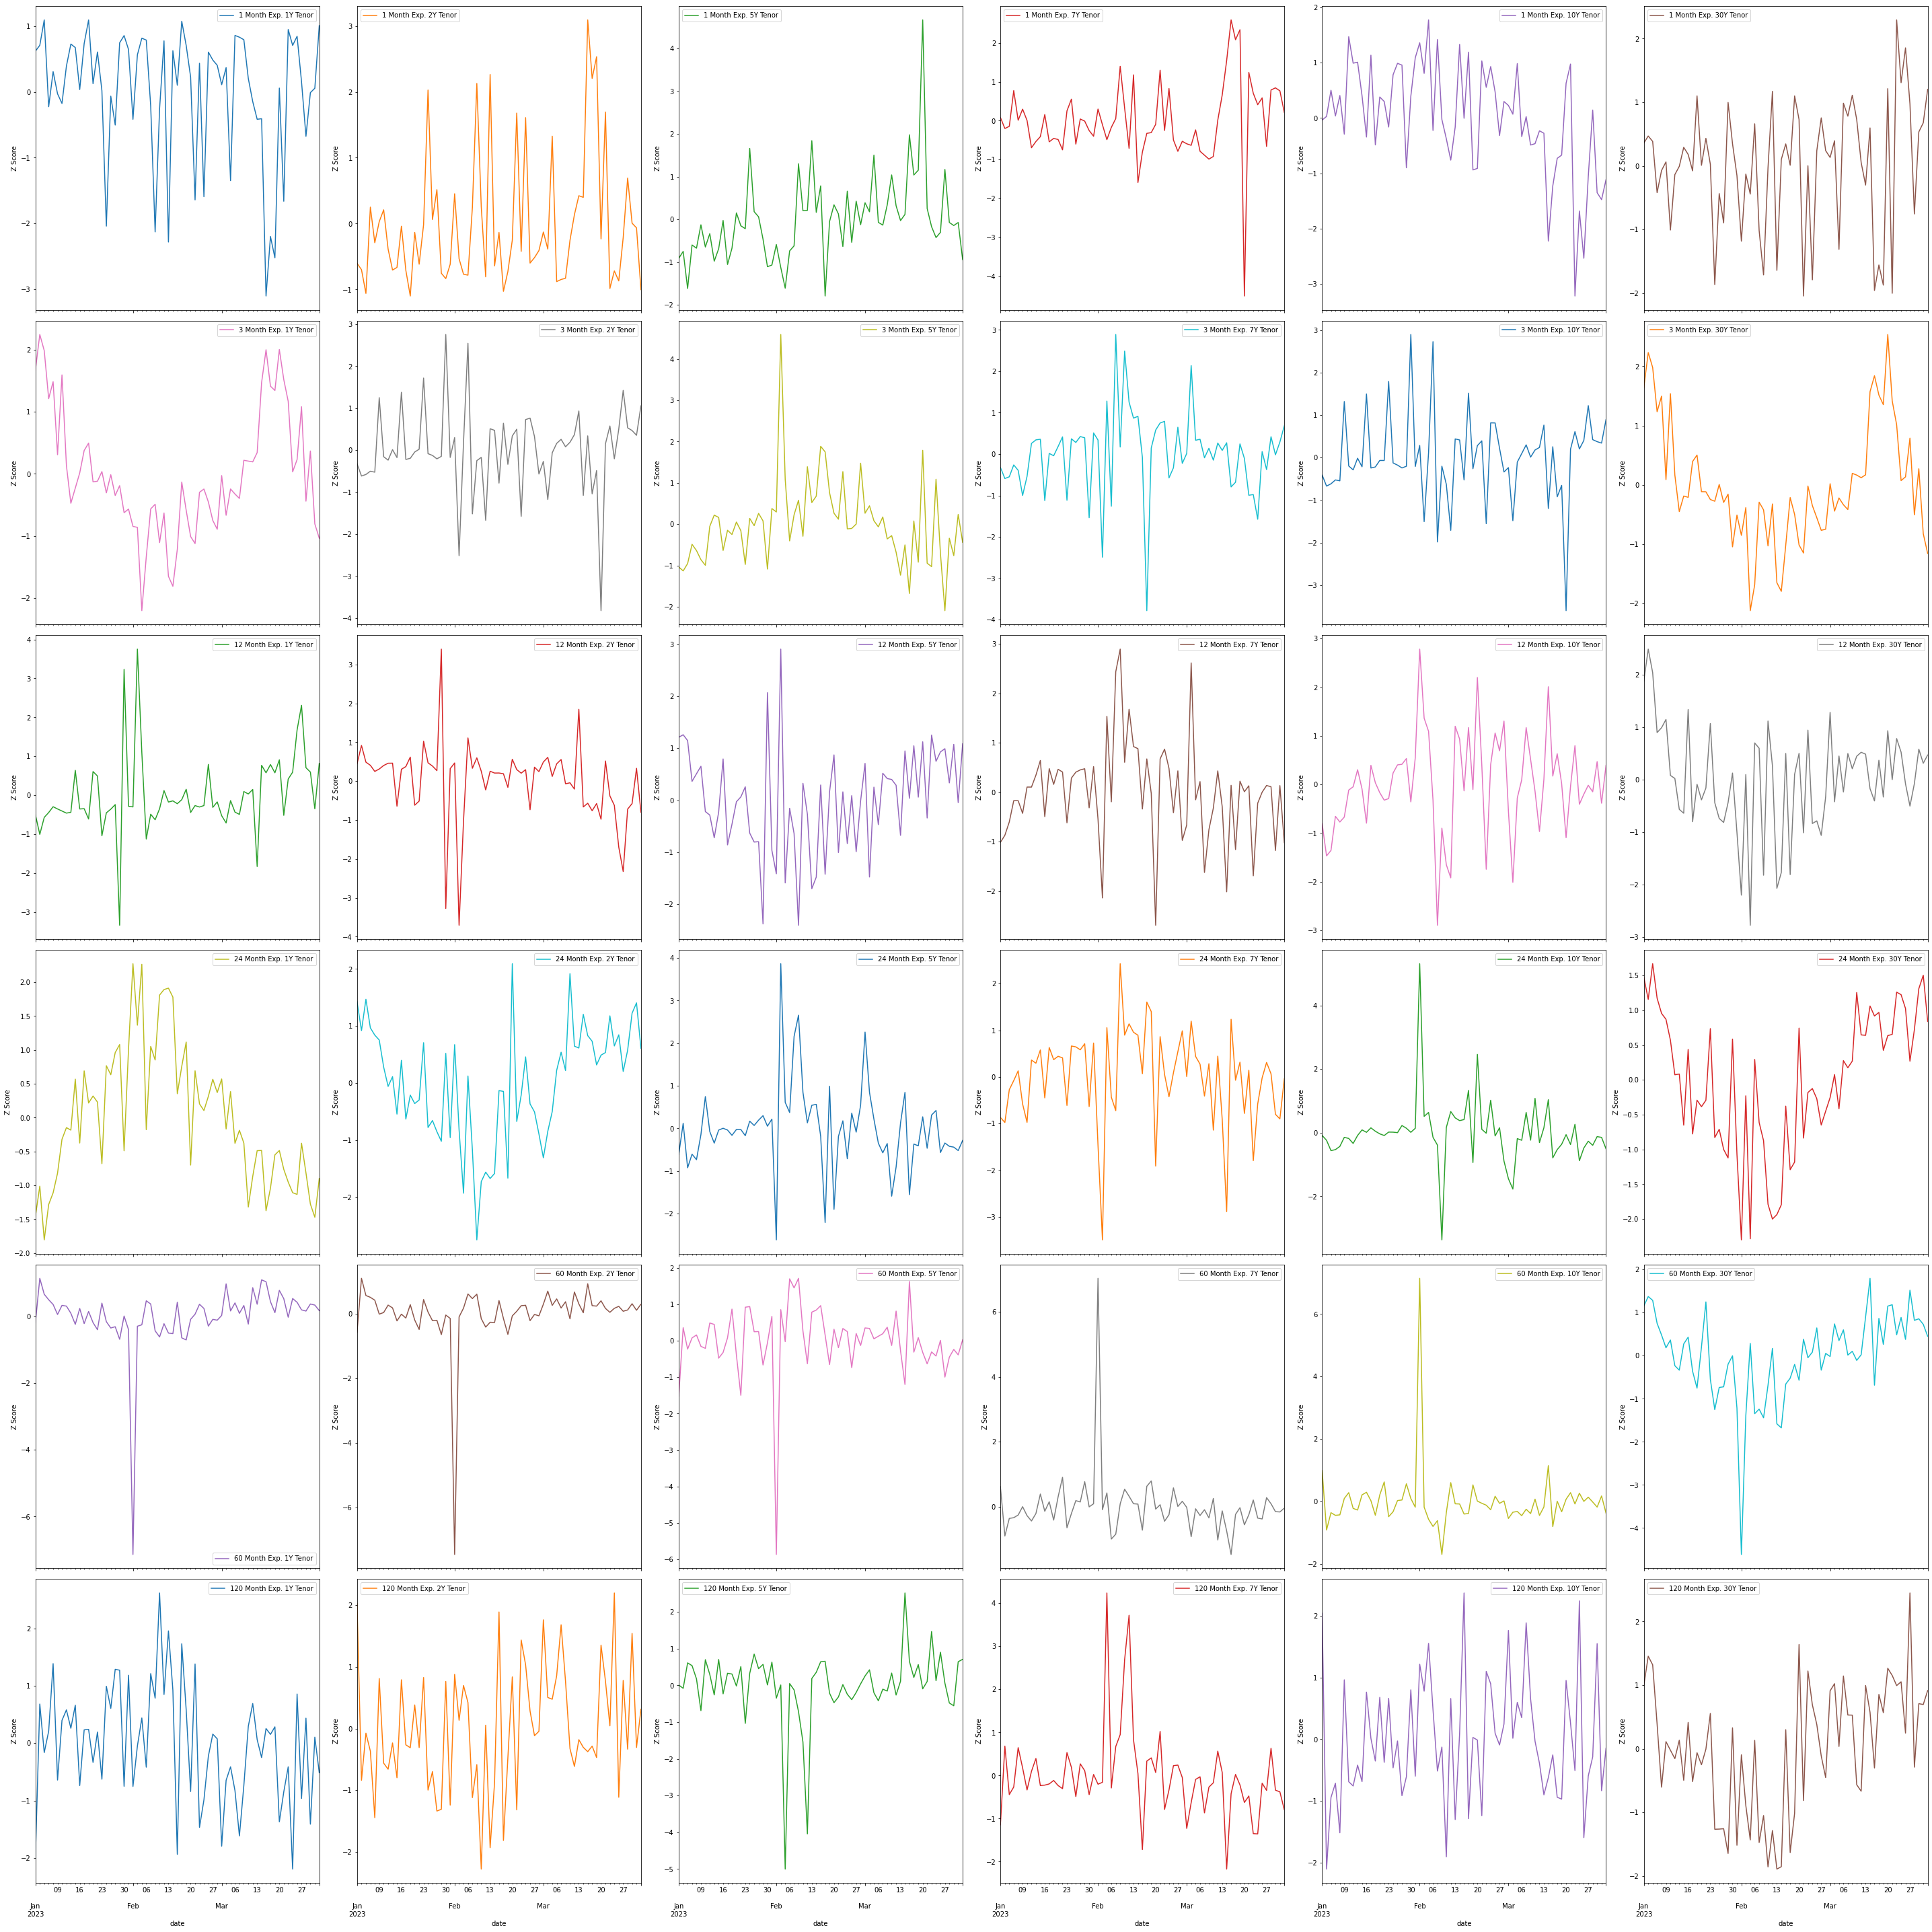

In [73]:
df_z_score_plot = (df_pca.query(
    "category == 'z_score_window'").
    drop(columns = ["category"]).
    assign(
        expiry_month = lambda x: x.expiry_month.astype(str) + " Month Exp.",
        variable = lambda x: x.variable.astype(str) + "Y Tenor").
    pivot(index = "date", columns = ["expiry_month", "variable"], values = "value"))

df_z_score_plot.columns = [' '.join(col) for col in df_z_score_plot.columns]

(df_z_score_plot.plot(
    subplots = True, layout = (6,6), figsize = (40,40),
    ylabel = "Z Score"))

fig.suptitle("Z Score from Residuals PCA Model of ATM Swaption Straddles from {} to {}".format(
    df_z_score_plot.index.min().date(), df_z_score_plot.index.max().date()))
plt.tight_layout()
plt.show()

## Create Matrix of z-scores

In [74]:
z_score_matrix = (df_pca.query(
    "category == 'z_score_window' & date == date.max()").
    drop(columns = ["date", "category"]).
    rename(columns = {"expiry_month": "Expiries (Month)", "variable": "Tenors (Year)"}).
    pivot(index = "Expiries (Month)", columns = "Tenors (Year)", values = "value"))

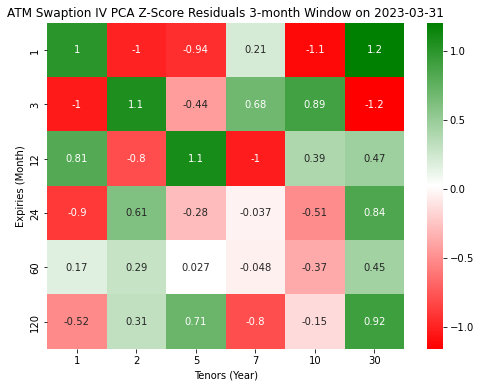

In [77]:
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(figsize = (8,6))

cmap = LinearSegmentedColormap.from_list(
    name='RdGr', 
    colors=['red','white','green'])

matrix = (sns.heatmap(
    z_score_matrix, annot = True, cmap = cmap).
    set(title = "ATM Swaption IV PCA Z-Score Residuals 3-month Window on {}".format(df_pca.date.max().date())))